In [2]:
%matplotlib inline
import warnings

warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import mdtraj as md

## Overview
In this notebook I:
1. plot the frozen trajectories initialized from trajectory 4 at times 151, 152, and 154 ns, and
2. cluster the unfrozen trajectory but this work was only exploratory and did not lead anywhere. 

In [3]:
dt_ps = 0.1
dt = dt_ps/1000

In [4]:
def get_trajectory(traj_path, top_path):
    
    traj = md.load(traj_path,top=top_path)

    com = md.compute_center_of_mass(traj)

    df = pd.DataFrame(com, columns=['x', 'y', 'z'])
    df['t'] = traj.time/1000 # Gromacs trajectories are in picoseconds - we want nanoseconds 
    
    return df

In [5]:
def get_csv_trajectory(traj_path, top_path=None):
    df = pd.read_csv(traj_path, header=None, names=['t', 'x', 'y', 'z'])
    df['t'] /= 1000 
    return df

In [6]:
def rotate_3d_plot(df, nrows=2,ncols=3, fig=None, elevation=0, scatt_kw={}):
    if fig is None: 
        fig = plt.figure()
    num_rotations = nrows*ncols
    for i in range(num_rotations):
        ax = fig.add_subplot(nrows,ncols,i+1,projection='3d')
        x = df.x
        y = df.y
        z = df.z
        col = df.t
        ax.scatter(xs=x, ys=y, zs=z, c=col,**scatt_kw)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.view_init(azim=(360/num_rotations)*i,elev=elevation)
    plt.tight_layout()
    return fig

## Plot Frozen Trajectories

In [7]:
frozen_151 = get_csv_trajectory('data/4_151ns_com_positions.csv')
frozen_152 = get_csv_trajectory('data/4_152ns_com_positions.csv')
frozen_154 = get_trajectory('data/4_154ns_400K_just-water.xtc', 'data/water_top.pdb')


In [8]:
# The original time doesn't mean much as it's not a sensible trajectory
frozen_151['t'] = 151
frozen_152['t'] = 152
frozen_154['t'] = 154
frozen = pd.concat([frozen_151, frozen_152, frozen_154])
frozen.head()

,t,x,y,z
0,151,1.25630,1.99070,1.07702
1,151,1.31668,2.04162,1.12011
2,151,1.35380,2.07816,1.15042
3,151,1.39639,2.09764,1.19310
4,151,1.39499,2.11216,1.22249


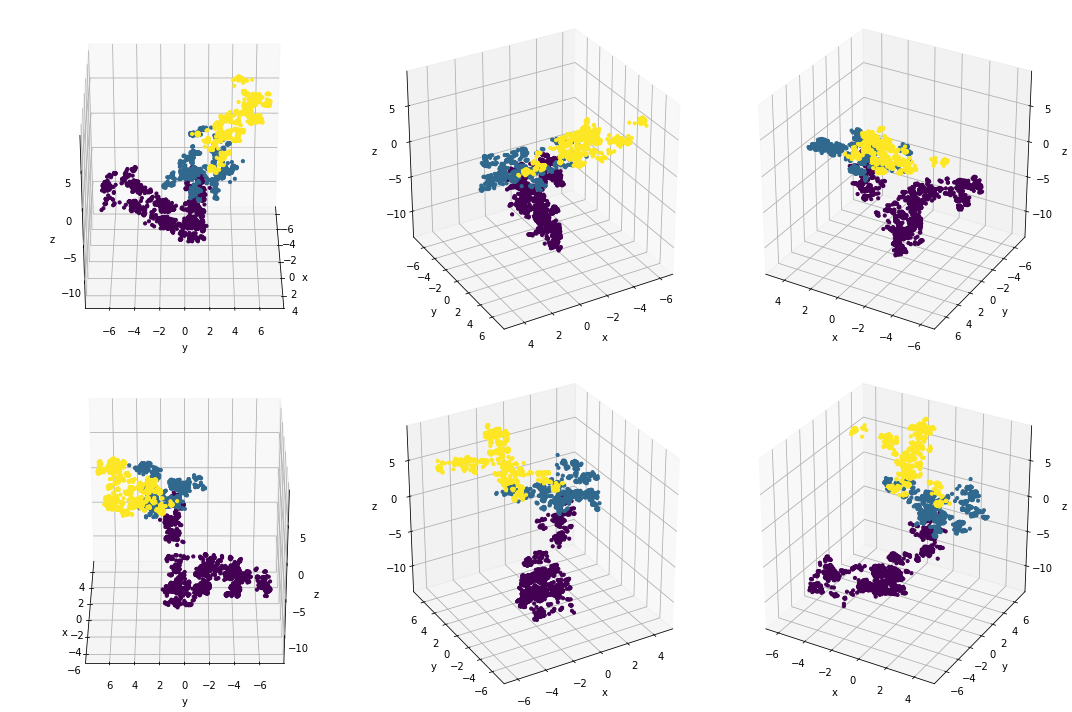

In [9]:
fig = plt.figure(figsize=(15,10))
stride=100
for i in range(6):
    ax = fig.add_subplot(2,3,i+1,projection='3d')
    x = frozen.iloc[::stride, 1]
    y = frozen.iloc[::stride, 2]
    z = frozen.iloc[::stride, 3]
    lab = frozen.iloc[::stride, 0]
    ax.scatter(xs=x, ys=y, zs=z, c=lab, s=10, alpha=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(azim=60*i)
plt.tight_layout()


## Cluster unfrozen trajectory

In [10]:
unfrozen = get_trajectory('data/traj_4.xtc', 'data/water_top.pdb')
unfrozen = unfrozen.loc[(unfrozen['t']>=151) & (unfrozen['t']<=154), :]

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [12]:
dt = round(unfrozen.iloc[1,-1] - unfrozen.iloc[0, -1], 4)
dt

1e-04

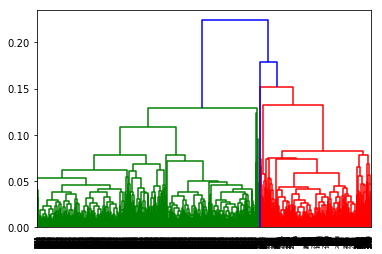

In [13]:
stride=10
Z_unfrozen = linkage(unfrozen.iloc[::stride, :3], method='average', metric='euclidean')
_ = dendrogram(Z_unfrozen, labels=None)

In [14]:
unfrozen_labels = fcluster(Z_unfrozen, criterion='distance', t=0.175)

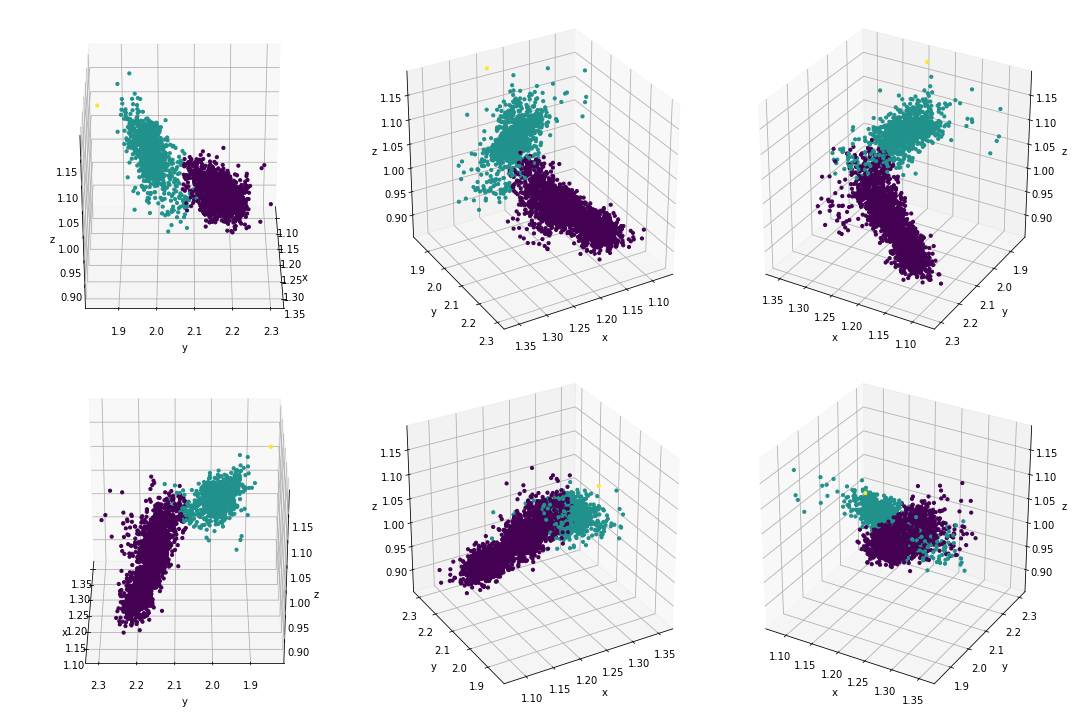

In [15]:
fig = plt.figure(figsize=(15,10))
for i in range(6):
    ax = fig.add_subplot(2,3,i+1,projection='3d')
    x = unfrozen.iloc[::stride, 0]
    y = unfrozen.iloc[::stride, 1]
    z = unfrozen.iloc[::stride, 2]
    ax.scatter(xs=x, ys=y, zs=z, c=unfrozen_labels, s=10, alpha=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(azim=60*i)
plt.tight_layout()

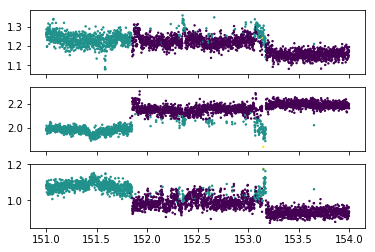

In [16]:
fig, axes = plt.subplots(3, sharex=True)
for i, ax in enumerate(axes):
    ax.scatter(unfrozen.iloc[::stride, -1], unfrozen.iloc[::stride, i ], c=unfrozen_labels,
              alpha=1, s=2)